In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.layers import Conv2D

C:\Users\himasing\.conda\envs\tf-cpu\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
Using TensorFlow backend.


In [2]:
#Image file path looks like this - C:\Users\himasing\Documents\DeepLearning\Project\fruits_data_set_2017_12_28\Training\f1\0_100.jpg
# Define root path accordingly, notice last "f1" and "f"
rootPath = "fruits_data_set_2017_12_28\\Training\\f"

First verify that input data is correct 

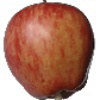

In [3]:
Image.open(rootPath + "1\\0_100.jpg")

Using Keras Image Library

In [4]:
# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [5]:
img = load_img(rootPath + "1\\0_100.jpg", color_mode = "grayscale")

In [6]:
img.show()

In [7]:
img_array = img_to_array(img)

In [8]:
img_array.shape

(100, 100, 1)

In [9]:
import os
i = 0
dir1 = rootPath + str(i+1)
images = os.listdir(rootPath + str(i+1))
len(images)

492

 we define a function to get "COLORED" Images. Data is form of pairs <image1, image2> and label = 1 when both images are from same folder, otherwise label = 0

In [10]:
size = 2
total_sample_size = 15000


def get_data_coloredImages(size, total_sample_size):
    #read the image
    image_p = load_img(rootPath + "1\\0_100.jpg")
    image = img_to_array(image_p)
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]
    channels = image.shape[2]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, dim1, dim2, channels])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(33):
        for j in range(int(total_sample_size/33)):
            ind1 = 0
            ind2 = 0
            
            dir1 = rootPath + str(i+1)
            images = os.listdir(rootPath + str(i+1))
            no_images = len(images)
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(no_images - 1)
                ind2 = np.random.randint(no_images - 1)
            
            # read the two images
            #img1 = read_image('att_faces\\s' + str(i+1) + '\\' + str(ind1 + 1) + '.pgm', 'rw+')
            #img2 = read_image('att_faces\\s' + str(i+1) + '\\' + str(ind2 + 1) + '.pgm', 'rw+')
            #print(images[ind1])
            image1 = load_img(dir1 + "\\" + images[ind1])
            image2 = load_img(dir1 + "\\" + images[ind2])
            
            img1 = img_to_array(image1)
            img2 = img_to_array(image2)
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, :, :, :] = img1
            x_geuine_pair[count, 1, :, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, dim1, dim2, channels])
    y_imposite = np.zeros([total_sample_size, 1])
    
    #For any given class, we will take first 400 images only
    for i in range(int(total_sample_size/200)):
        for j in range(200):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(33)
                ind2 = np.random.randint(33)
                if ind1 != ind2:
                    break
                    
            dir1 = rootPath + str(ind1+1)
            dir2 = rootPath + str(ind2+1)
            images1 = os.listdir(dir1)
            images2 = os.listdir(dir2)
            #img1 = read_image('att_faces\\s' + str(ind1+1) + '\\' + str(j + 1) + '.pgm', 'rw+')
            #img2 = read_image('att_faces\\s' + str(ind2+1) + '\\' + str(j + 1) + '.pgm', 'rw+')

            image1 = load_img(dir1 + "\\" + images1[j+1])
            image2 = load_img(dir2 + "\\" + images2[j+1])
            
            img1 = img_to_array(image1)
            img2 = img_to_array(image2)
            
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, :, :, :] = img1
            x_imposite_pair[count, 1, :, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

Now, we generate our data and check our data size. As you can see we have 20,000 data points, out of these 10,000 are genuine pairs and 10,000 are imposite pairs. 

In [12]:
X, Y = get_data_coloredImages(size, total_sample_size)

In [13]:
X.shape

(30000, 2, 50, 50, 3)

Verifying data that it is loaded correctly.

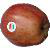

In [14]:
from keras.preprocessing.image import save_img

loadedImage = X[0,0,:,:,:]
index = np.random.randint(5000)
save_img('sampleData' + str(index) + '.jpg', loadedImage)
# load the image to confirm it was saved correctly
Image.open('sampleData' + str(index) + '.jpg')

In [18]:
Y.shape

(30000, 1)

Next, we split our data for training and testing with 75% training and 25% testing proportions:

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

Now that, we have successfully generated our data, we build our siamese network. First, we define the base network which is basically a convolutional network used for feature extraction. We build two convolutional layers with rectified linear unit (ReLU) activations and max pooling followed by flat layer.

In [20]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='tf'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='tf'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq


In [22]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
img_a

<tf.Tensor 'input_1:0' shape=(?, 50, 50, 3) dtype=float32>

Next, we feed the image pair, to the base network, which will return the embeddings that is, feature vectors:

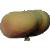

In [28]:
x_train.shape
loadedImage = x_train[4,0,:,:,:]
index = np.random.randint(5000)
save_img('sampleData' + str(index) + '.jpg', loadedImage)
# load the image to confirm it was saved correctly
Image.open('sampleData' + str(index) + '.jpg')

In [29]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

C:\Users\himasing\.conda\envs\tf-cpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), padding="valid", input_shape=(50, 50, 3..., data_format="channels_last")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\himasing\.conda\envs\tf-cpu\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), padding="valid", data_format="channels_last")`
C:\Users\himasing\.conda\envs\tf-cpu\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`


In [30]:
feat_vecs_a

<tf.Tensor 'sequential_1/dense_2/Relu:0' shape=(?, 50) dtype=float32>

These feat_vecs_a and feat_vecs_b are the feature vectors of our image pair. Next, we feed this feature vectors to the energy function to compute the distance between them, we use Euclidean distance as our energy function.

In [31]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [32]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

 Now, we set the epoch length to 13 and we use RMS prop for optimization and define our model.

In [33]:
epochs = 10
rms = RMSprop()

In [34]:
model = Model(input=[img_a, img_b], output=distance)

C:\Users\himasing\.conda\envs\tf-cpu\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


Next, we define our loss function as contrastive_loss function and compile the model. 

In [35]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [36]:
model.compile(loss=contrastive_loss, optimizer=rms)

In [136]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           193262      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]               
          

In [37]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [38]:
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=2, nb_epoch=epochs)

C:\Users\himasing\.conda\envs\tf-cpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 16875 samples, validate on 5625 samples
Epoch 1/10
 - 60s - loss: 0.1494 - val_loss: 0.1086
Epoch 2/10
 - 54s - loss: 0.0836 - val_loss: 0.0800
Epoch 3/10
 - 54s - loss: 0.0672 - val_loss: 0.0660
Epoch 4/10
 - 54s - loss: 0.0587 - val_loss: 0.0574
Epoch 5/10
 - 55s - loss: 0.0526 - val_loss: 0.0461
Epoch 6/10
 - 57s - loss: 0.0481 - val_loss: 0.0429
Epoch 7/10
 - 60s - loss: 0.0435 - val_loss: 0.0380
Epoch 8/10
 - 62s - loss: 0.0403 - val_loss: 0.0308
Epoch 9/10
 - 54s - loss: 0.0368 - val_loss: 0.0330
Epoch 10/10
 - 55s - loss: 0.0339 - val_loss: 0.0271


Now, we make predictions with test data

In [39]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [40]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

Finally, we check our model accuracy. 

In [41]:
compute_accuracy(pred, y_test)

0.95180418874589956

Now we check, few samples that predictions are correct for some samples

In [56]:
pred

array([[ 0.01503554],
       [ 0.11913591],
       [ 1.456797  ],
       ..., 
       [ 0.01728344],
       [ 0.09507292],
       [ 0.07101206]], dtype=float32)

In [131]:
index_in_test = 9

In [132]:
y_test[index_in_test]

array([ 0.])

In [133]:
(pred.ravel() < 0.5)[index_in_test]

False

## Negative example - Data pairs

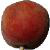

In [134]:
loadedImage = x_test[index_in_test, 0, :, :, :]
index = np.random.randint(5000)
save_img('sampleData' + str(index) + '.jpg', loadedImage)
# load the image to confirm it was saved correctly
Image.open('sampleData' + str(index) + '.jpg')



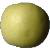

In [135]:
loadedImage = x_test[index_in_test, 1, :, :, :]
index = np.random.randint(5000)
save_img('sampleData' + str(index) + '.jpg', loadedImage)
# load the image to confirm it was saved correctly
Image.open('sampleData' + str(index) + '.jpg')